In [1]:
import importlib.util
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
lumapiFile = "C:\\Program Files\\Lumerical\\v242\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

interApi = lumapi.INTERCONNECT(hide = False)

In [4]:
interApi.expressioncheckoff()

In [5]:
um = 1e-6
nm = 1e-9
valor_lambda = 1550*nm
start_wavelenth = 1500*nm
stop_wavelenth = 1600*nm
number_point = 100000

neff = 2.35317

file = 'CDWM_PDK'

In [6]:
interApi.save(file)

In [7]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)

In [8]:
interApi.switchtolayout()

interApi.select('Acoplador_Direcional')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'Acoplador_Direcional')

In [9]:
coupling_length_05 = 17.5*um

In [10]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional', 'opt_1')
interApi.connect('Acoplador_Direcional', 'opt_3', 'ONA', 'input 1')
interApi.connect('Acoplador_Direcional', 'opt_4', 'ONA', 'input 2')

1.0

In [16]:
coupling_length = 0*um

coupling_length_029 = 0

while coupling_length_029 == 0:
    interApi.switchtolayout()

    interApi.setnamed('Acoplador_Direcional', 'coupling_length', coupling_length)

    interApi.run(1)

    FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
    FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

    wavelength_2 = np.array(FSR_2['wavelength']).flatten()
    transmission_2 = np.array(FSR_2["TE gain (dB)"])

    target_wavelength = 1550*nm
    
    index_1550_2 = np.argmin(np.abs(wavelength_2 - target_wavelength))

    if coupling_length_029 == 0 and np.isclose(10**((transmission_2[index_1550_2]/10)), 0.29, atol=1e-2):
        coupling_length_029 = coupling_length
        print('-----COUPLING OF 0.29-----')
        print(f"Valor real encontrado: {wavelength_2[index_1550_2]/nm:.2f} nm")
        print(f"Ganho correspondente: {transmission_2[index_1550_2]:.2f} dB")
        print(f'Tamanho do guia do acoplador = {coupling_length_029/um:.2f}um')
    
    coupling_length = coupling_length + 0.5*um

-----COUPLING OF 0.29-----
Valor real encontrado: 1550.00 nm
Ganho correspondente: -5.44 dB
Tamanho do guia do acoplador = 11.50um


In [17]:
interApi.disconnect('ONA', 'output', 'Acoplador_Direcional', 'opt_1')
interApi.connect('ONA', 'output', 'Acoplador_Direcional', 'opt_2')

1.0

In [18]:
coupling_length = 0*um

coupling_length_008 = 0

while coupling_length_008 == 0:
    interApi.switchtolayout()

    interApi.setnamed('Acoplador_Direcional', 'coupling_length', coupling_length)

    interApi.run(1)

    FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')

    wavelength_1 = np.array(FSR_1['wavelength']).flatten()
    transmission_1 = np.array(FSR_1["TE gain (dB)"])

    target_wavelength = 1550*nm

    index_1550_1 = np.argmin(np.abs(wavelength_1 - target_wavelength))

    if coupling_length_008 == 0 and np.isclose(10**((transmission_1[index_1550_1]/10)), 0.08, atol=1e-2):
        coupling_length_008 = coupling_length
        print('-----COUPLING OF 0.08-----')
        print(f"Valor real encontrado: {wavelength_1[index_1550_1]/nm:.2f} nm")
        print(f"Ganho correspondente: {transmission_1[index_1550_1]:.2f} dB")
        print(f'Tamanho do guia do acoplador = {coupling_length_008/um:.2f}um')
    
    coupling_length = coupling_length + 0.5*um

-----COUPLING OF 0.08-----
Valor real encontrado: 1550.00 nm
Ganho correspondente: -11.19 dB
Tamanho do guia do acoplador = 4.00um


In [19]:
interApi.switchtolayout()
interApi.selectall()
interApi.delete()

In [20]:
ng = 4.3458796
esp = [50/nm, 100/nm, 200/nm]

FSR = np.zeros(len(esp))

L1 = 25*um
L2 = np.zeros((len(FSR),7))

d_L = np.zeros((len(FSR),7))

for i in range (len(FSR)):
    FSR[i] = valor_lambda**2/(c/esp[i])

    d_L_base = valor_lambda**2/(2*FSR[i]*ng)
    d_L_FS = valor_lambda/neff
    
    d_L_3 =  d_L_base
    d_L_2A = d_L_base/2
    d_L_2B = d_L_base/2 + 0.75*d_L_FS
    d_L_1A = d_L_base/4
    d_L_1B = d_L_base/4 + 0.250*d_L_FS
    d_L_1C = d_L_base/4 + 0.125*d_L_FS
    d_L_1D = d_L_base/4 + 0.375*d_L_FS

    d_L[i] = [d_L_3, d_L_2A, d_L_2B, d_L_1A, d_L_1B, d_L_1C, d_L_1D]

    for j in range (7):
        L2[i][j] = L1 + d_L[i][j]

    print(f'Para um espaçamento de {esp[i]*nm:.0f} GHz, FSR = {FSR[i]/nm:.2f} nm:')
    print(F'\u0394L_EST1 = {d_L[i][0]/um:.2f} \u03BCm')
    print(F'Comprimento maior EST1-1 = {L2[i][0]/um:.2f} \u03BCm e Comprimento maior EST1-2 = {(L2[i][0]+d_L[i][0])/um:.2f} \u03BCm\n')
    print(F'\u0394L_EST2A = {d_L[i][1]/um:.2f} \u03BCm e \u0394L_EST2B = {d_L[i][2]/um:.2f} \u03BCm')
    print(F'Comprimento maior EST2A-1 = {L2[i][1]/um:.2f} \u03BCm e Comprimento maior EST2A-2 = {(L2[i][1]+d_L[i][1])/um:.2f} \u03BCm')
    print(F'Comprimento maior EST2B-1 = {L2[i][2]/um:.2f} \u03BCm e Comprimento maior EST2B-2 = {(L2[i][2]+d_L[i][2])/um:.2f} \u03BCm\n')
    print(F'\u0394L_EST3A = {d_L[i][3]/um:.2f} \u03BCm, \u0394L_EST3B = {d_L[i][4]/um:.2f} \u03BCm, \u0394L_EST3C = {d_L[i][5]/um:.2f} \u03BCm e \u0394L_EST3D = {d_L[i][6]/um:.2f} \u03BCm')
    print(F'Comprimento maior EST3A-1 = {L2[i][3]/um:.2f} \u03BCm e Comprimento maior EST3A-2 = {(L2[i][3]+d_L[i][3])/um:.2f} \u03BCm')
    print(F'Comprimento maior EST3B-1 = {L2[i][4]/um:.2f} \u03BCm e Comprimento maior EST3B-2 = {(L2[i][4]+d_L[i][4])/um:.2f} \u03BCm')
    print(F'Comprimento maior EST3C-1 = {L2[i][5]/um:.2f} \u03BCm e Comprimento maior EST3C-2 = {(L2[i][5]+d_L[i][5])/um:.2f} \u03BCm')
    print(F'Comprimento maior EST3D-1 = {L2[i][6]/um:.2f} \u03BCm e Comprimento maior EST3D-2 = {(L2[i][6]+d_L[i][6])/um:.2f} \u03BCm')
    print(F'Comprimento menor = {L1/um:.2f} \u03BCm\n')

Para um espaçamento de 50 GHz, FSR = 0.40 nm:
ΔL_EST1 = 689.83 μm
Comprimento maior EST1-1 = 714.83 μm e Comprimento maior EST1-2 = 1404.66 μm

ΔL_EST2A = 344.92 μm e ΔL_EST2B = 345.41 μm
Comprimento maior EST2A-1 = 369.92 μm e Comprimento maior EST2A-2 = 714.83 μm
Comprimento maior EST2B-1 = 370.41 μm e Comprimento maior EST2B-2 = 715.82 μm

ΔL_EST3A = 172.46 μm, ΔL_EST3B = 172.62 μm, ΔL_EST3C = 172.54 μm e ΔL_EST3D = 172.70 μm
Comprimento maior EST3A-1 = 197.46 μm e Comprimento maior EST3A-2 = 369.92 μm
Comprimento maior EST3B-1 = 197.62 μm e Comprimento maior EST3B-2 = 370.25 μm
Comprimento maior EST3C-1 = 197.54 μm e Comprimento maior EST3C-2 = 370.08 μm
Comprimento maior EST3D-1 = 197.70 μm e Comprimento maior EST3D-2 = 370.41 μm
Comprimento menor = 25.00 μm

Para um espaçamento de 100 GHz, FSR = 0.80 nm:
ΔL_EST1 = 344.92 μm
Comprimento maior EST1-1 = 369.92 μm e Comprimento maior EST1-2 = 714.83 μm

ΔL_EST2A = 172.46 μm e ΔL_EST2B = 172.95 μm
Comprimento maior EST2A-1 = 197.46 μm

In [21]:
x_ona = 3500
y_ona = -1000

x_waveguide_maior = 25
y_waveguide_maior = 150

x_waveguide_menor = 25
y_waveguide_menor = 300

x_y_branch = -150
y_y_branch = 225

x_acoplador_direcional = 300
y_acoplador_direcional = 225

distancia = 450
distancia_y = 75

In [22]:
interApi.switchtolayout()

interApi.select('Acoplador_Direcional_in')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'Acoplador_Direcional_in')
interApi.set('coupling_length', coupling_length_05)
interApi.setposition('Acoplador_Direcional_in', x_y_branch, y_y_branch)

In [23]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}')
    interApi.setposition(f'WGD_maior_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[0][0] + i*d_L[0][0])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}')
    interApi.setposition(f'WGD_menor_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [24]:
interApi.switchtolayout()

for i in range (2):
    interApi.select(f'Acoplador_Direcional_{i+1}')
    interApi.delete()

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_{i+1}')
    if i+1 == 1:
        interApi.set('coupling_length', coupling_length_029)
    else:
        interApi.set('coupling_length', coupling_length_008)
    interApi.setposition(f'Acoplador_Direcional_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(i+1)*distancia, y_acoplador_direcional)

In [25]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [26]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in', 'opt_3', f'WGD_maior_1', 'port 1')
interApi.connect('Acoplador_Direcional_in', 'opt_4', f'WGD_menor_1', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_4', f'WGD_maior_{i+2}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_3', f'WGD_menor_{i+2}', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_1')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_4', 'ONA', f'input {i+2}')

In [27]:
file = 'CDWM_PDK_50'

In [28]:
interApi.save(file)

In [29]:
interApi.run(1)

In [30]:
FSR_GAIN = [None]*2
wavelength_GAIN = [None]*2
transmission_GAIN = [None]*2

for i in range (2):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

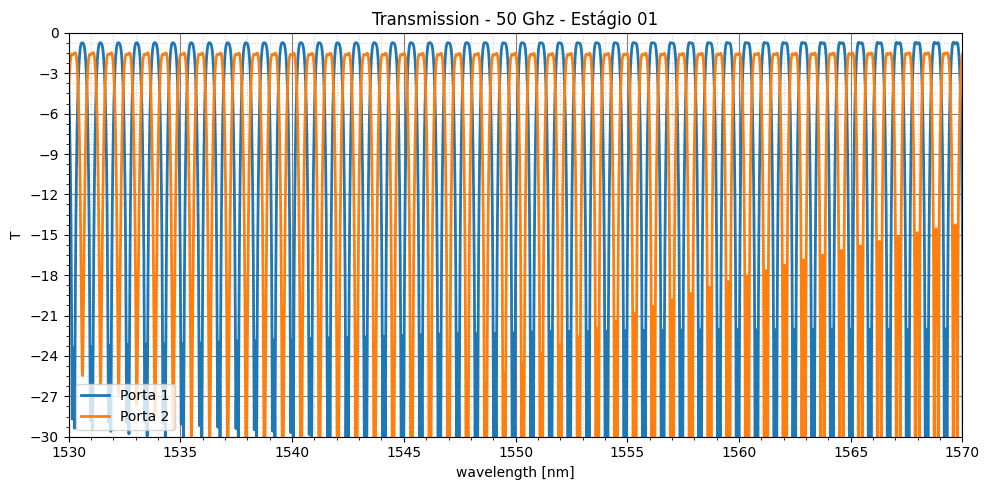

In [31]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 01')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 01.png')
plt.show()

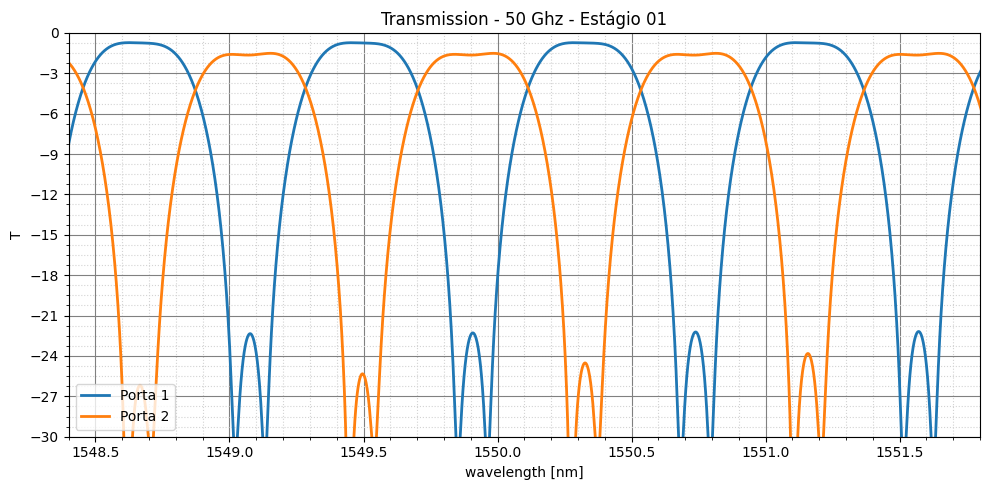

In [32]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+18.4, (stop_wavelenth/nm)-30-18.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 01')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 01 - zoom.png')
plt.show()

In [33]:
interApi.switchtolayout()

interApi.select('Acoplador_Direcional_in_A')
interApi.delete()
interApi.select('Acoplador_Direcional_in_B')
interApi.delete()

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'Acoplador_Direcional_in_A')
interApi.set('coupling_length', coupling_length_05)
interApi.setposition('Acoplador_Direcional_in_A', x_acoplador_direcional+3/2*distancia, y_y_branch-distancia)

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'Acoplador_Direcional_in_B')
interApi.set('coupling_length', coupling_length_05)
interApi.setposition('Acoplador_Direcional_in_B', x_acoplador_direcional+3/2*distancia, y_y_branch+distancia)

In [34]:
interApi.connect('Acoplador_Direcional_2', 'opt_3', 'Acoplador_Direcional_in_A', 'opt_2')
interApi.connect('Acoplador_Direcional_2', 'opt_4', 'Acoplador_Direcional_in_B', 'opt_1')

1.0

In [35]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_maior_{i+1}_B')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_B')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_A')
    interApi.setposition(f'WGD_maior_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[0][1] + i*d_L[0][1])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_A')
    interApi.setposition(f'WGD_menor_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_B')
    interApi.setposition(f'WGD_maior_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[0][2] + i*d_L[0][2])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_B')
    interApi.setposition(f'WGD_menor_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [36]:
interApi.switchtolayout()

for i in range (2):
    interApi.select(f'Acoplador_Direcional_{i+1}_A')
    interApi.delete()
    interApi.select(f'Acoplador_Direcional_{i+1}_B')
    interApi.delete()

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_{i+1}_A')
    if i+1 == 1:
        interApi.set('coupling_length', coupling_length_029)
    else:
        interApi.set('coupling_length', coupling_length_008)
    interApi.setposition(f'Acoplador_Direcional_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(i+1)*distancia, interApi.getnamed('Acoplador_Direcional_in_A','y position'))
    
    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_{i+1}_B')
    if i+1 == 1:
        interApi.set('coupling_length', coupling_length_029)
    else:
        interApi.set('coupling_length', coupling_length_008)
    interApi.setposition(f'Acoplador_Direcional_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(i+1)*distancia, interApi.getnamed('Acoplador_Direcional_in_B','y position'))

In [37]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 4)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [38]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in_A', 'opt_3', f'WGD_maior_1_A', 'port 1')
interApi.connect('Acoplador_Direcional_in_A', 'opt_4', f'WGD_menor_1_A', 'port 1')

interApi.connect('Acoplador_Direcional_in_B', 'opt_3', f'WGD_maior_1_B', 'port 1')
interApi.connect('Acoplador_Direcional_in_B', 'opt_4', f'WGD_menor_1_B', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_4', f'WGD_maior_{i+2}_A', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_3', f'WGD_menor_{i+2}_A', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_4', 'ONA', f'input {i+2}')

    interApi.connect(f'WGD_maior_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_4', f'WGD_maior_{i+2}_B', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_3', f'WGD_menor_{i+2}_B', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_3', 'ONA', f'input {i+3}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_4', 'ONA', f'input {i+4}')

In [39]:
interApi.save(file)

In [40]:
interApi.run(1)

In [42]:
FSR_GAIN = [None]*4
wavelength_GAIN = [None]*4
transmission_GAIN = [None]*4

for i in range (4):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

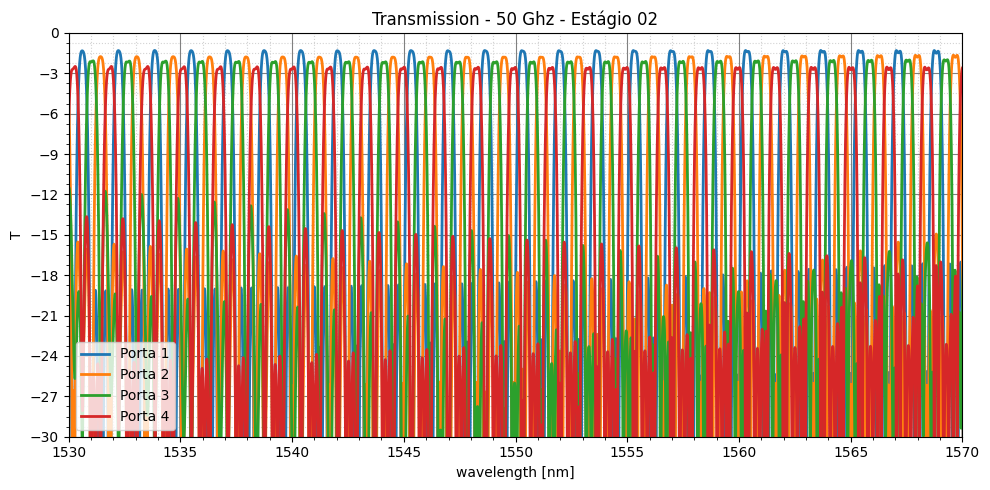

In [43]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 02')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 02.png')
plt.show()

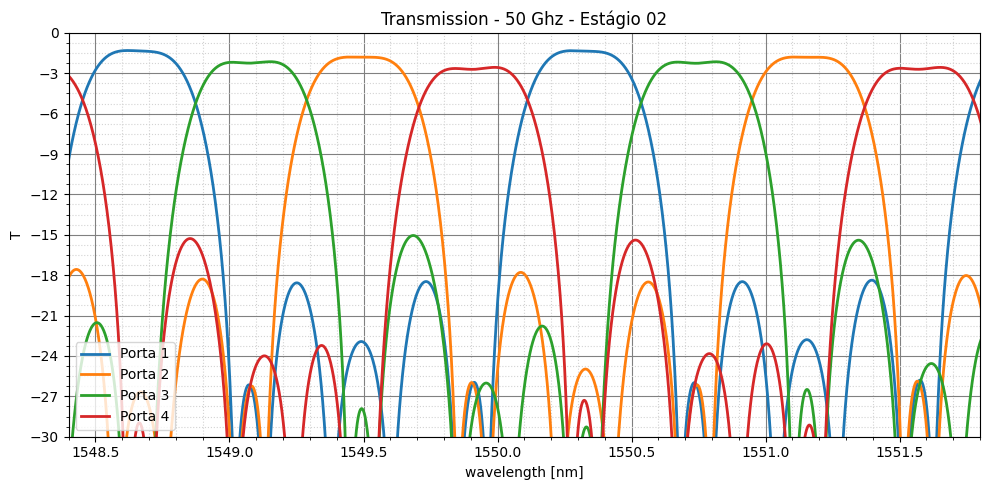

In [44]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+18.4, (stop_wavelenth/nm)-30-18.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 02')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 02 - zoom.png')
plt.show()

In [45]:
interApi.switchtolayout()

for i in range(2):
    interApi.select(f'Acoplador_Direcional_in_A_{i+1}')
    interApi.delete()
    interApi.select(f'Acoplador_Direcional_in_B_{i+1}')
    interApi.delete()

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_in_A_{i+1}')
    interApi.set('coupling_length', coupling_length_05)
    interApi.setposition(f'Acoplador_Direcional_in_A_{i+1}', x_acoplador_direcional+4*distancia, interApi.getnamed('Acoplador_Direcional_in_A','y position')+((-1)**(i+1))*1/2*distancia)

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', f'Acoplador_Direcional_in_B_{i+1}')
    interApi.set('coupling_length', coupling_length_05)
    interApi.setposition(f'Acoplador_Direcional_in_B_{i+1}', x_acoplador_direcional+4*distancia, interApi.getnamed('Acoplador_Direcional_in_B','y position')+((-1)**(i+1))*1/2*distancia)

In [46]:
for i in range (2):
    interApi.connect('Acoplador_Direcional_2_A', f'opt_{3+i}', f'Acoplador_Direcional_in_A_{i+1}', f'opt_{-(i-2)}')
    interApi.connect('Acoplador_Direcional_2_B', f'opt_{3+i}', f'Acoplador_Direcional_in_B_{i+1}', f'opt_{-(i-2)}')

In [47]:
interApi.switchtolayout()

for j in range (2):
    for i in range (2):
        interApi.select(f'WGD_maior_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_maior_{i+1}_B_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_B_{j+1}')
        interApi.delete()

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[0][3+j] + i*d_L[0][3+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[0][5+j] + i*d_L[0][5+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

In [48]:
interApi.switchtolayout()

for j in range (2):
    for i in range (2):
        interApi.select(f'Acoplador_Direcional_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'Acoplador_Direcional_{i+1}_B_{j+1}')
        interApi.delete()

        interApi.addelement('ebeam_dc_te1550')
        interApi.set('name', f'Acoplador_Direcional_{i+1}_A_{j+1}')
        if i+1 == 1:
            interApi.set('coupling_length', coupling_length_029)
        else:
            interApi.set('coupling_length', coupling_length_008)
        interApi.setposition(f'Acoplador_Direcional_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(i+1)*distancia, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position'))
        
        interApi.addelement('ebeam_dc_te1550')
        interApi.set('name', f'Acoplador_Direcional_{i+1}_B_{j+1}')
        if i+1 == 1:
            interApi.set('coupling_length', coupling_length_029)
        else:
            interApi.set('coupling_length', coupling_length_008)
        interApi.setposition(f'Acoplador_Direcional_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(i+1)*distancia, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position'))

In [49]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 8)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [50]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')

for j in range (2):
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_3', f'WGD_maior_1_A_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_4', f'WGD_menor_1_A_{j+1}', 'port 1')

    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_3', f'WGD_maior_1_B_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_4', f'WGD_menor_1_B_{j+1}', 'port 1')

    for i in range (1):
        interApi.connect(f'WGD_maior_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_4', f'WGD_maior_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_3', f'WGD_menor_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_3', 'ONA', f'input {1+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_4', 'ONA', f'input {2+2*j}')

        interApi.connect(f'WGD_maior_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_4', f'WGD_maior_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_3', f'WGD_menor_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_3', 'ONA', f'input {5+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_4', 'ONA', f'input {6+2*j}')

In [51]:
interApi.save(file)

In [52]:
interApi.run(1)

In [53]:
FSR_GAIN = [None]*8
wavelength_GAIN = [None]*8
transmission_GAIN = [None]*8

for i in range (8):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])


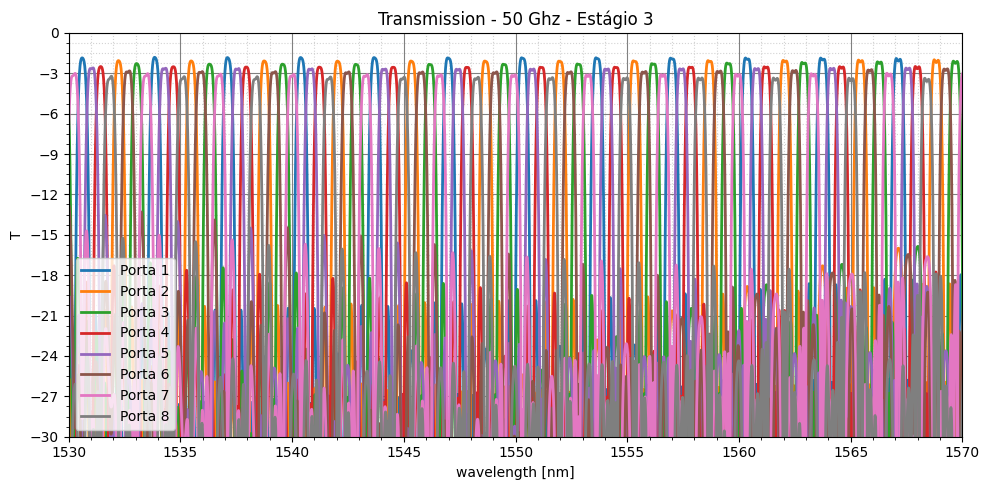

In [54]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 3.png')
plt.show()

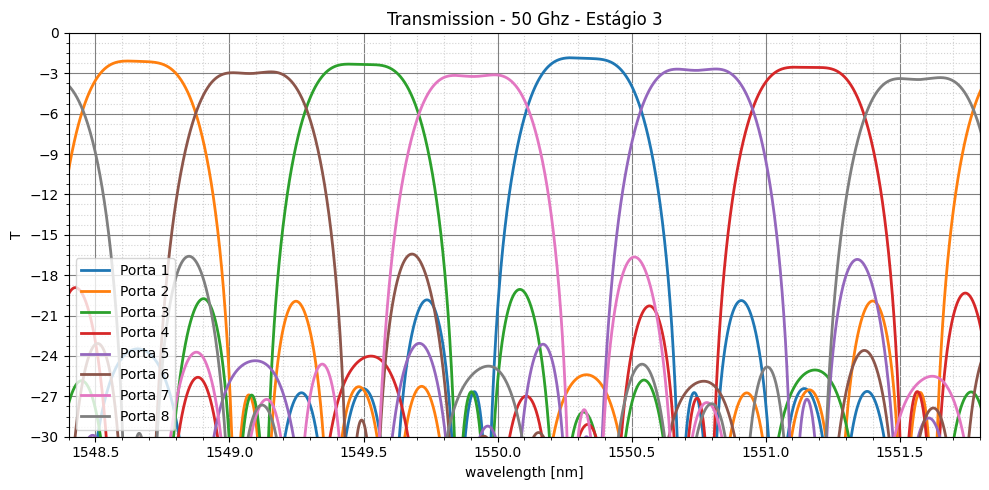

In [55]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+18.4, (stop_wavelenth/nm)-30-18.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 50 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 50 Ghz - Estagio 3 - zoom.png')
plt.show()

100 Ghz

In [56]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}')
    interApi.setposition(f'WGD_maior_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[1][0] + i*d_L[1][0])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}')
    interApi.setposition(f'WGD_menor_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [57]:
interApi.disconnect('Acoplador_Direcional_2', 'opt_3', 'Acoplador_Direcional_in_A', 'opt_2')
interApi.disconnect('Acoplador_Direcional_2', 'opt_4', 'Acoplador_Direcional_in_B', 'opt_1')

In [58]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [59]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in', 'opt_3', f'WGD_maior_1', 'port 1')
interApi.connect('Acoplador_Direcional_in', 'opt_4', f'WGD_menor_1', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_4', f'WGD_maior_{i+2}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_3', f'WGD_menor_{i+2}', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_1')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_4', 'ONA', f'input {i+2}')

In [60]:
file = 'CDWM_PDK_100'

In [61]:
interApi.save(file)

In [62]:
interApi.run(1)

In [63]:
FSR_GAIN = [None]*2
wavelength_GAIN = [None]*2
transmission_GAIN = [None]*2

for i in range (2):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

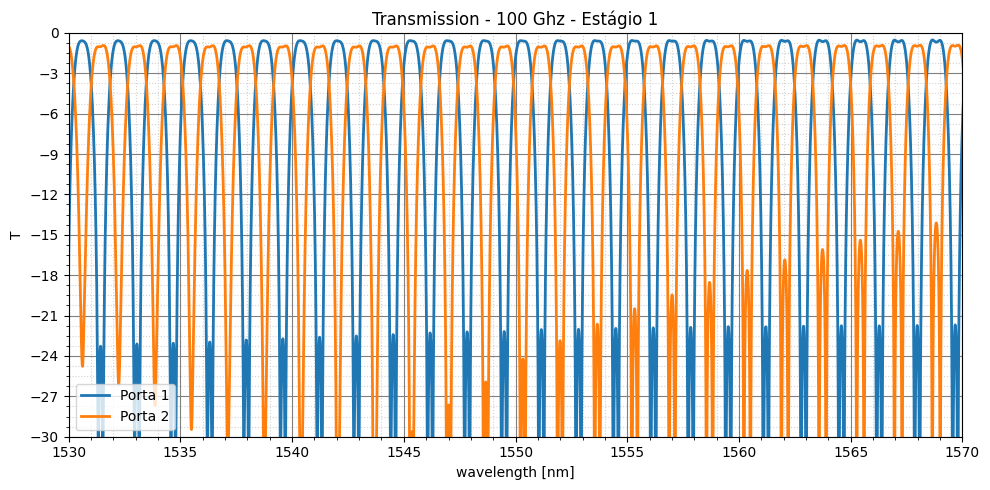

In [64]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 1')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 1.png')
plt.show()

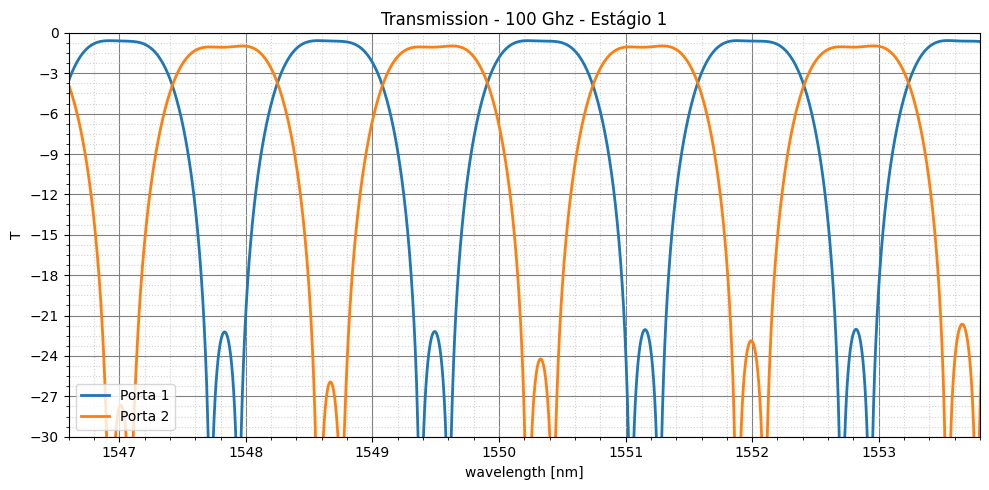

In [65]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+16.6, (stop_wavelenth/nm)-30-16.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 1')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 1 - zoom.png')
plt.show()

In [66]:
interApi.connect('Acoplador_Direcional_2', 'opt_3', 'Acoplador_Direcional_in_A', 'opt_2')
interApi.connect('Acoplador_Direcional_2', 'opt_4', 'Acoplador_Direcional_in_B', 'opt_1')

1.0

In [67]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_maior_{i+1}_B')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_B')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_A')
    interApi.setposition(f'WGD_maior_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[1][1] + i*d_L[1][1])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_A')
    interApi.setposition(f'WGD_menor_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_B')
    interApi.setposition(f'WGD_maior_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[1][2] + i*d_L[1][2])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_B')
    interApi.setposition(f'WGD_menor_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [68]:
for i in range (2):
    interApi.disconnect('Acoplador_Direcional_2_A', f'opt_{3+i}', f'Acoplador_Direcional_in_A_{i+1}', f'opt_{-(i-2)}')
    interApi.disconnect('Acoplador_Direcional_2_B', f'opt_{3+i}', f'Acoplador_Direcional_in_B_{i+1}', f'opt_{-(i-2)}')

In [69]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 4)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [70]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in_A', 'opt_3', f'WGD_maior_1_A', 'port 1')
interApi.connect('Acoplador_Direcional_in_A', 'opt_4', f'WGD_menor_1_A', 'port 1')

interApi.connect('Acoplador_Direcional_in_B', 'opt_3', f'WGD_maior_1_B', 'port 1')
interApi.connect('Acoplador_Direcional_in_B', 'opt_4', f'WGD_menor_1_B', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_4', f'WGD_maior_{i+2}_A', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_3', f'WGD_menor_{i+2}_A', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_4', 'ONA', f'input {i+2}')

    interApi.connect(f'WGD_maior_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_4', f'WGD_maior_{i+2}_B', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_3', f'WGD_menor_{i+2}_B', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_3', 'ONA', f'input {i+3}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_4', 'ONA', f'input {i+4}')

In [71]:
interApi.save(file)

In [72]:
interApi.run(1)

In [73]:
FSR_GAIN = [None]*4
wavelength_GAIN = [None]*4
transmission_GAIN = [None]*4

for i in range (4):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

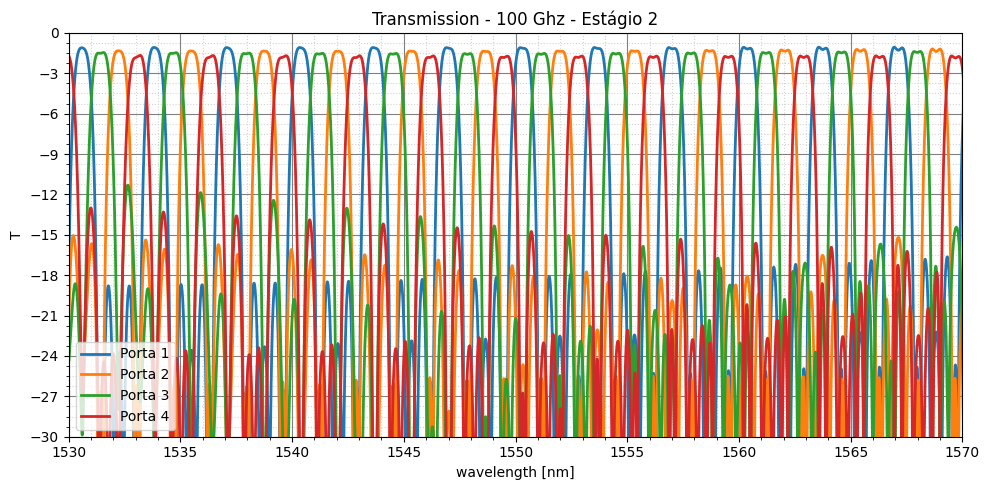

In [74]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 2')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 2.png')
plt.show()

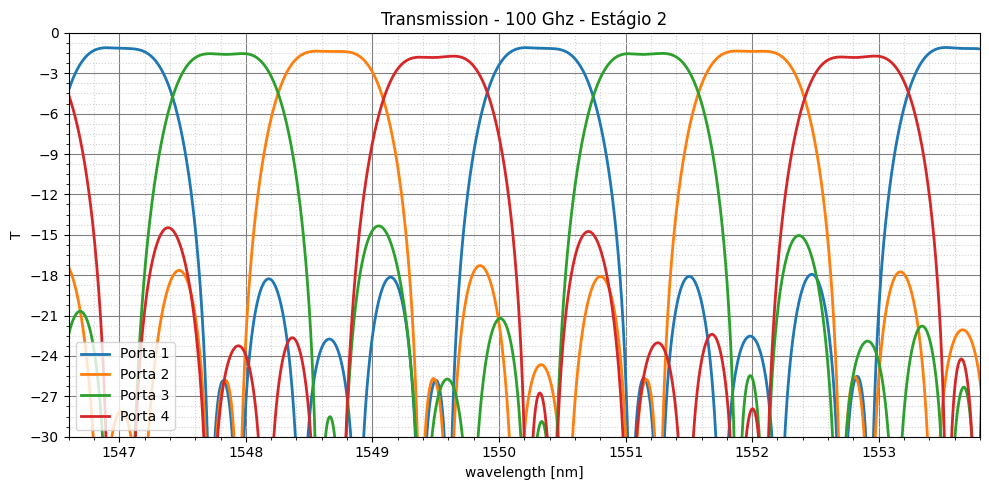

In [75]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+16.6, (stop_wavelenth/nm)-30-16.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 2')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 2 - zoom.png')
plt.show()

In [76]:
for i in range (2):
    interApi.connect('Acoplador_Direcional_2_A', f'opt_{3+i}', f'Acoplador_Direcional_in_A_{i+1}', f'opt_{-(i-2)}')
    interApi.connect('Acoplador_Direcional_2_B', f'opt_{3+i}', f'Acoplador_Direcional_in_B_{i+1}', f'opt_{-(i-2)}')

In [77]:
interApi.switchtolayout()

for j in range (2):
    for i in range (2):
        interApi.select(f'WGD_maior_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_maior_{i+1}_B_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_B_{j+1}')
        interApi.delete()

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[1][3+j] + i*d_L[1][3+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[1][5+j] + i*d_L[1][5+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

In [78]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 8)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [79]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')

for j in range (2):
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_3', f'WGD_maior_1_A_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_4', f'WGD_menor_1_A_{j+1}', 'port 1')

    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_3', f'WGD_maior_1_B_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_4', f'WGD_menor_1_B_{j+1}', 'port 1')

    for i in range (1):
        interApi.connect(f'WGD_maior_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_4', f'WGD_maior_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_3', f'WGD_menor_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_3', 'ONA', f'input {1+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_4', 'ONA', f'input {2+2*j}')

        interApi.connect(f'WGD_maior_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_4', f'WGD_maior_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_3', f'WGD_menor_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_3', 'ONA', f'input {5+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_4', 'ONA', f'input {6+2*j}')

In [80]:
interApi.save(file)

In [81]:
interApi.run(1)

In [82]:
FSR_GAIN = [None]*8
wavelength_GAIN = [None]*8
transmission_GAIN = [None]*8

for i in range (8):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

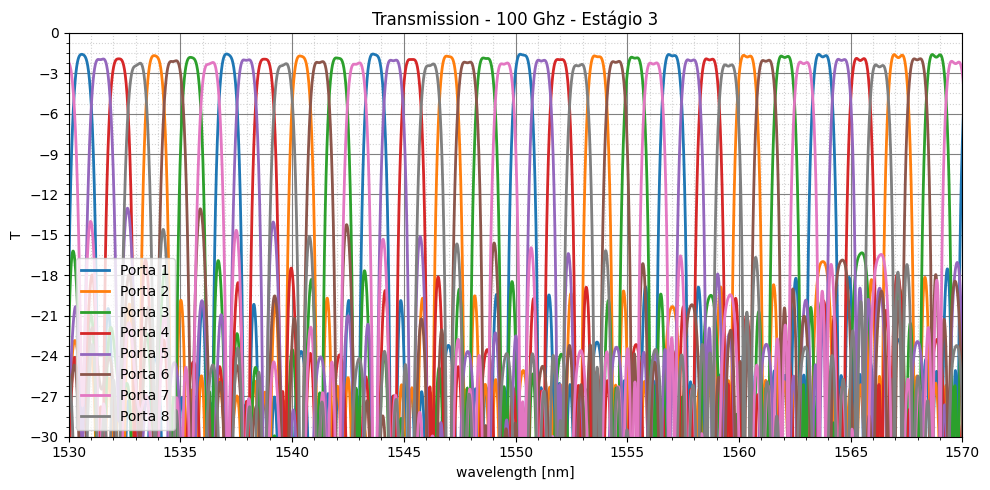

In [83]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 3.png')
plt.show()

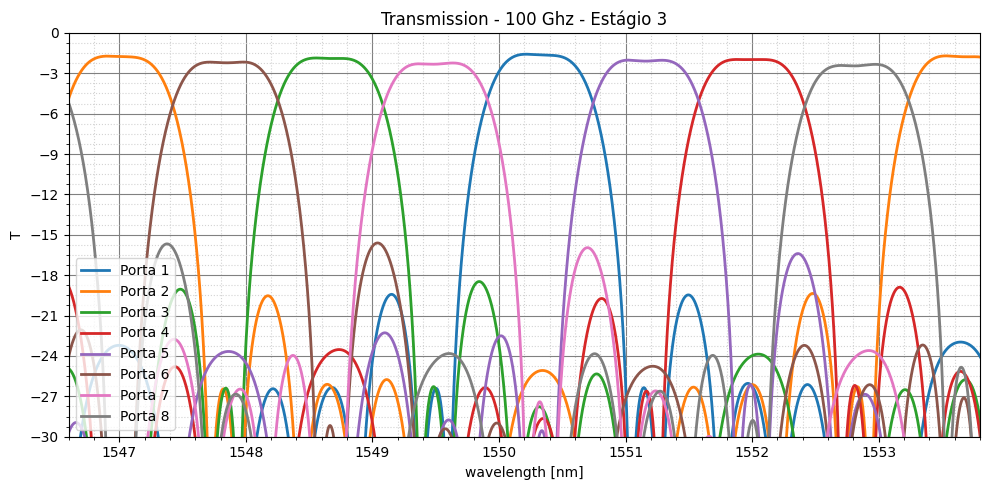

In [84]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+16.6, (stop_wavelenth/nm)-30-16.2])
plt.ylim([-30, 0])
plt.title(r'Transmission - 100 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 100 Ghz - Estagio 3 - zoom.png')
plt.show()

200 Ghz

In [85]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}')
    interApi.setposition(f'WGD_maior_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[2][0] + i*d_L[2][0])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}')
    interApi.setposition(f'WGD_menor_{i+1}', interApi.getnamed('Acoplador_Direcional_in','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [86]:
interApi.disconnect('Acoplador_Direcional_2', 'opt_3', 'Acoplador_Direcional_in_A', 'opt_2')
interApi.disconnect('Acoplador_Direcional_2', 'opt_4', 'Acoplador_Direcional_in_B', 'opt_1')

In [87]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [88]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in', 'opt_3', f'WGD_maior_1', 'port 1')
interApi.connect('Acoplador_Direcional_in', 'opt_4', f'WGD_menor_1', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}', 'port 2', f'Acoplador_Direcional_{i+1}', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_4', f'WGD_maior_{i+2}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}', 'opt_3', f'WGD_menor_{i+2}', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}', 'port 2', f'Acoplador_Direcional_{i+2}', 'opt_1')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}', 'opt_4', 'ONA', f'input {i+2}')

In [89]:
file = 'CDWM_PDK_200'

In [90]:
interApi.save(file)

In [91]:
interApi.run(1)

In [92]:
FSR_GAIN = [None]*2
wavelength_GAIN = [None]*2
transmission_GAIN = [None]*2

for i in range (2):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

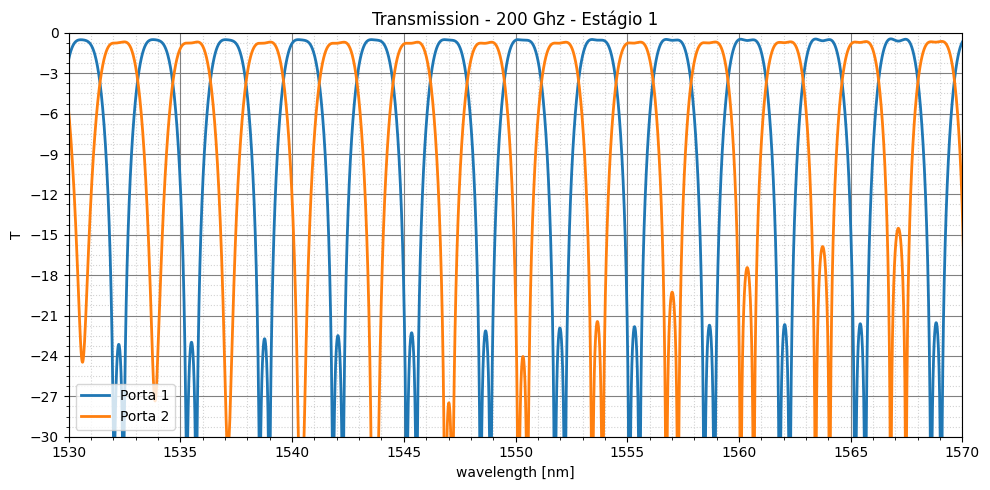

In [93]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 1')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 1.png')
plt.show()

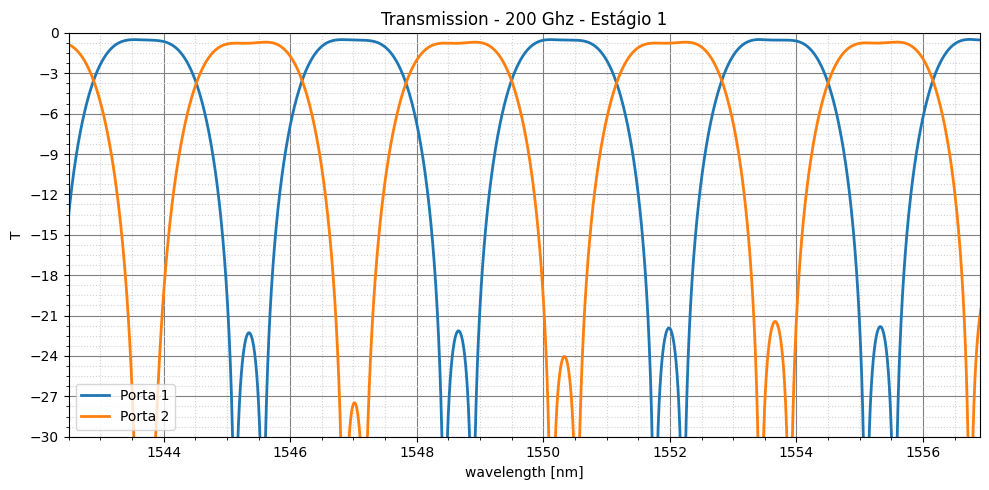

In [94]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(2):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+12.5, (stop_wavelenth/nm)-30-13.1])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 1')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 1 - zoom.png')
plt.show()

In [95]:
interApi.connect('Acoplador_Direcional_2', 'opt_3', 'Acoplador_Direcional_in_A', 'opt_2')
interApi.connect('Acoplador_Direcional_2', 'opt_4', 'Acoplador_Direcional_in_B', 'opt_1')

1.0

In [96]:
interApi.switchtolayout()

for i in range (2):

    interApi.select(f'WGD_maior_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_A')
    interApi.delete()
    interApi.select(f'WGD_maior_{i+1}_B')
    interApi.delete()
    interApi.select(f'WGD_menor_{i+1}_B')
    interApi.delete()

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_A')
    interApi.setposition(f'WGD_maior_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[2][1] + i*d_L[2][1])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_A')
    interApi.setposition(f'WGD_menor_{i+1}_A', interApi.getnamed('Acoplador_Direcional_in_A','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_A','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_maior_{i+1}_B')
    interApi.setposition(f'WGD_maior_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') + ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L2[2][2] + i*d_L[2][2])

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name', f'WGD_menor_{i+1}_B')
    interApi.setposition(f'WGD_menor_{i+1}_B', interApi.getnamed('Acoplador_Direcional_in_B','x position')+(2*i+1)*distancia/2, interApi.getnamed('Acoplador_Direcional_in_B','y position') - ((-1)**(i+1))*distancia_y)
    interApi.set('wg_length', L1)

In [97]:
for i in range (2):
    interApi.disconnect('Acoplador_Direcional_2_A', f'opt_{3+i}', f'Acoplador_Direcional_in_A_{i+1}', f'opt_{-(i-2)}')
    interApi.disconnect('Acoplador_Direcional_2_B', f'opt_{3+i}', f'Acoplador_Direcional_in_B_{i+1}', f'opt_{-(i-2)}')

In [98]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 4)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [99]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')
interApi.connect('Acoplador_Direcional_in_A', 'opt_3', f'WGD_maior_1_A', 'port 1')
interApi.connect('Acoplador_Direcional_in_A', 'opt_4', f'WGD_menor_1_A', 'port 1')

interApi.connect('Acoplador_Direcional_in_B', 'opt_3', f'WGD_maior_1_B', 'port 1')
interApi.connect('Acoplador_Direcional_in_B', 'opt_4', f'WGD_menor_1_B', 'port 1')

for i in range (1):
    interApi.connect(f'WGD_maior_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_A', 'port 2', f'Acoplador_Direcional_{i+1}_A', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_4', f'WGD_maior_{i+2}_A', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_A', 'opt_3', f'WGD_menor_{i+2}_A', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_A', 'port 2', f'Acoplador_Direcional_{i+2}_A', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_3', 'ONA', f'input {i+1}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_A', 'opt_4', 'ONA', f'input {i+2}')

    interApi.connect(f'WGD_maior_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_1')
    interApi.connect(f'WGD_menor_{i+1}_B', 'port 2', f'Acoplador_Direcional_{i+1}_B', 'opt_2')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_4', f'WGD_maior_{i+2}_B', 'port 1')
    interApi.connect(f'Acoplador_Direcional_{i+1}_B', 'opt_3', f'WGD_menor_{i+2}_B', 'port 1')
    interApi.connect(f'WGD_maior_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_2')
    interApi.connect(f'WGD_menor_{i+2}_B', 'port 2', f'Acoplador_Direcional_{i+2}_B', 'opt_1')

    
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_3', 'ONA', f'input {i+3}')
    interApi.connect(f'Acoplador_Direcional_{i+2}_B', 'opt_4', 'ONA', f'input {i+4}')

In [100]:
interApi.save(file)

In [101]:
interApi.run(1)

In [102]:
FSR_GAIN = [None]*4
wavelength_GAIN = [None]*4
transmission_GAIN = [None]*4

for i in range (4):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

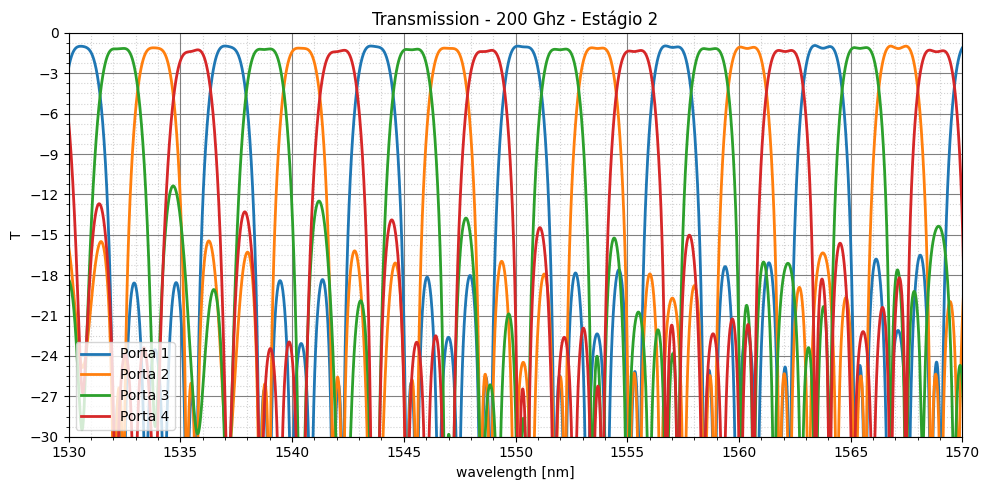

In [103]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 2')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 2.png')
plt.show()

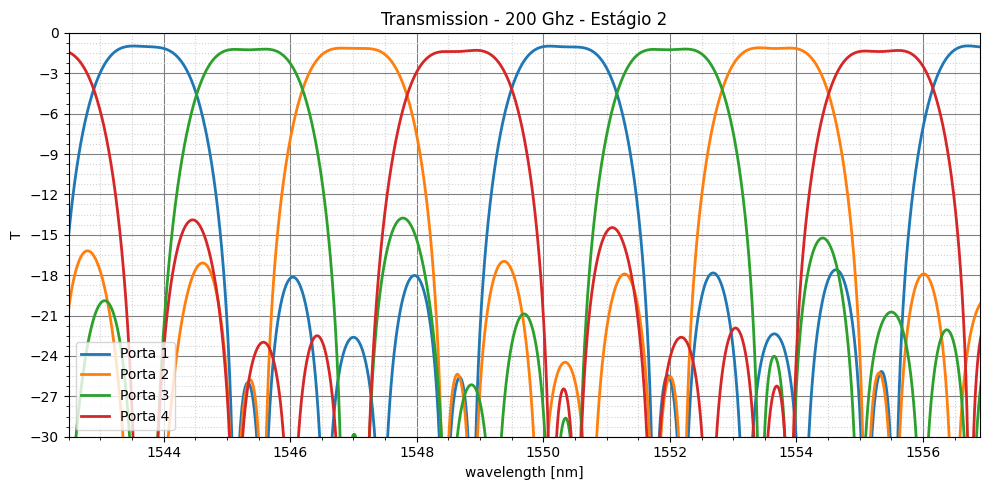

In [104]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(4):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+12.5, (stop_wavelenth/nm)-30-13.1])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 2')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 2 - zoom.png')
plt.show()

In [105]:
for i in range (2):
    interApi.connect('Acoplador_Direcional_2_A', f'opt_{3+i}', f'Acoplador_Direcional_in_A_{i+1}', f'opt_{-(i-2)}')
    interApi.connect('Acoplador_Direcional_2_B', f'opt_{3+i}', f'Acoplador_Direcional_in_B_{i+1}', f'opt_{-(i-2)}')

In [106]:
interApi.switchtolayout()

for j in range (2):
    for i in range (2):
        interApi.select(f'WGD_maior_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_A_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_maior_{i+1}_B_{j+1}')
        interApi.delete()
        interApi.select(f'WGD_menor_{i+1}_B_{j+1}')
        interApi.delete()

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[2][3+j] + i*d_L[2][3+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_A_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_A_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_A_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_maior_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_maior_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') + ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L2[2][5+j] + i*d_L[2][5+j])

        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name', f'WGD_menor_{i+1}_B_{j+1}')
        interApi.setposition(f'WGD_menor_{i+1}_B_{j+1}', interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','x position')+(2*i+1)*distancia/2, interApi.getnamed(f'Acoplador_Direcional_in_B_{j+1}','y position') - ((-1)**(i+1))*distancia_y)
        interApi.set('wg_length', L1)

In [107]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 8)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)
interApi.setnamed('ONA', 'Rotated', 45)

In [108]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_in', 'opt_2')

for j in range (2):
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_3', f'WGD_maior_1_A_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_A_{j+1}', 'opt_4', f'WGD_menor_1_A_{j+1}', 'port 1')

    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_3', f'WGD_maior_1_B_{j+1}', 'port 1')
    interApi.connect(f'Acoplador_Direcional_in_B_{j+1}', 'opt_4', f'WGD_menor_1_B_{j+1}', 'port 1')

    for i in range (1):
        interApi.connect(f'WGD_maior_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_4', f'WGD_maior_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_A_{j+1}', 'opt_3', f'WGD_menor_{i+2}_A_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_A_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_3', 'ONA', f'input {1+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_A_{j+1}', 'opt_4', 'ONA', f'input {2+2*j}')

        interApi.connect(f'WGD_maior_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_1')
        interApi.connect(f'WGD_menor_{i+1}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_2')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_4', f'WGD_maior_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'Acoplador_Direcional_{i+1}_B_{j+1}', 'opt_3', f'WGD_menor_{i+2}_B_{j+1}', 'port 1')
        interApi.connect(f'WGD_maior_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_2')
        interApi.connect(f'WGD_menor_{i+2}_B_{j+1}', 'port 2', f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_1')

        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_3', 'ONA', f'input {5+2*j}')
        interApi.connect(f'Acoplador_Direcional_{i+2}_B_{j+1}', 'opt_4', 'ONA', f'input {6+2*j}')

In [109]:
interApi.save(file)

In [110]:
interApi.run(1)

In [111]:
FSR_GAIN = [None]*8
wavelength_GAIN = [None]*8
transmission_GAIN = [None]*8

for i in range (8):
    FSR_GAIN[i] = interApi.getresult('ONA', f'input {i+1}/mode 1/gain')

    wavelength_GAIN[i] = np.array(FSR_GAIN[i]['wavelength']).flatten()
    transmission_GAIN[i] = np.array(FSR_GAIN[i]["TE gain (dB)"])

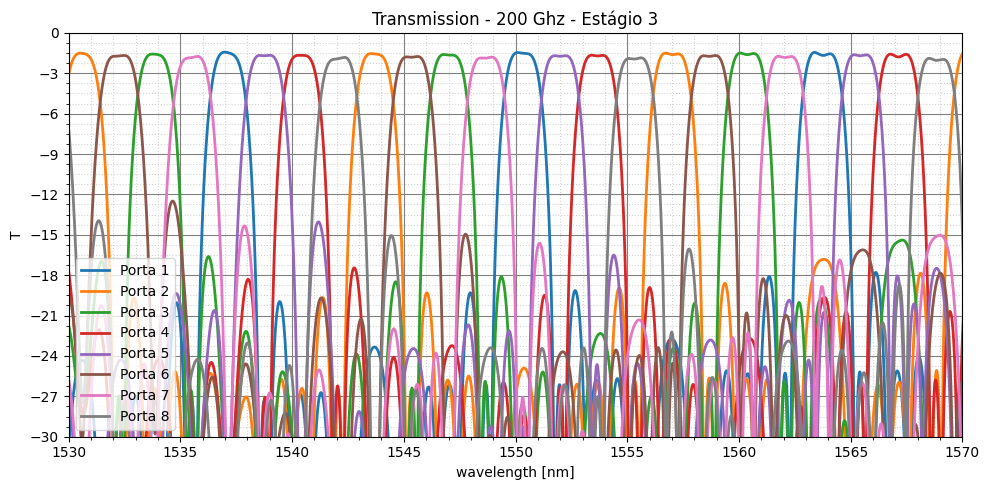

In [112]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30, (stop_wavelenth/nm)-30])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 3.png')
plt.show()

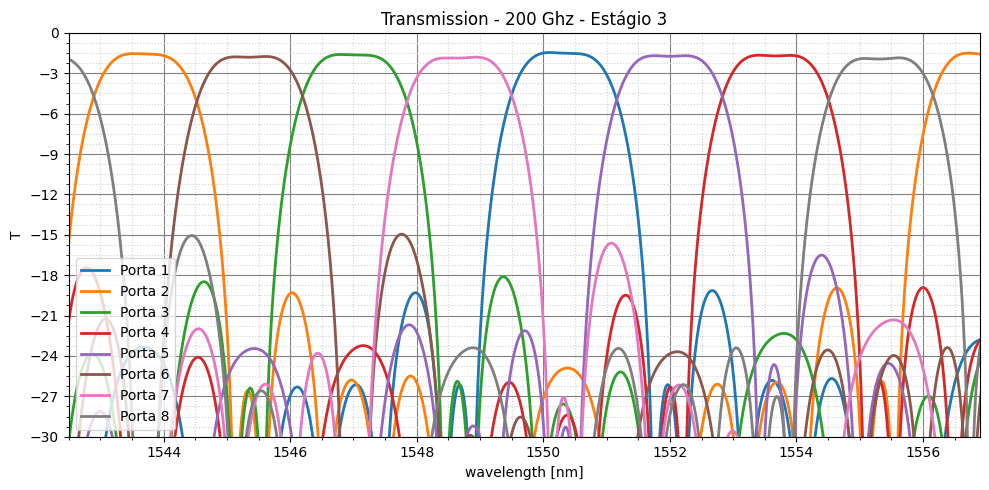

In [113]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

for i in range(8):
    plt.plot((wavelength_GAIN[i]/nm), transmission_GAIN[i], label = f'Porta {i+1}', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([(start_wavelenth/nm)+30+12.5, (stop_wavelenth/nm)-30-13.1])
plt.ylim([-30, 0])
plt.title(r'Transmission - 200 Ghz - Estágio 3')
plt.legend(loc='lower left')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')
plt.yticks(np.arange(-30, 0.01, 3))

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 200 Ghz - Estagio 3 - zoom.png')
plt.show()